Fake News Detection

In [1]:
import os
import pyspark
conf = pyspark.SparkConf()
# conf.set('spark.ui.proxyBase'
# , '/user/' + os.environ['JUPYTERHUB_USER'] + '/proxy/4041')
conf.set('spark.sql.repl.eagerEval.enabled', True)
conf.set('spark.driver.memory','4g')
sc = pyspark.SparkContext(conf=conf)
spark = pyspark.SQLContext.getOrCreate(sc)

22/12/20 14:15:31 WARN Utils: Your hostname, Poojas-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 172.20.10.3 instead (on interface en0)
22/12/20 14:15:31 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/12/20 14:15:33 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


/Users/poojaakki/opt/anaconda3/lib/python3.9/site-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [2]:
import pandas as pd
from pyspark.sql.types import StructType, StructField
from pyspark.sql.types import StringType

schema= StructType(
      [StructField('title',StringType(),True),
      StructField('text',StringType(),True),
      StructField('subject',StringType(),True),
      StructField('date',StringType(),True)])

df0 = pd.read_csv('/Users/poojaakki/Desktop/projects/Fake-News-Detection-Data-Analysis/datasets/Kaggle/fake.csv')
df1 = pd.read_csv('/Users/poojaakki/Desktop/projects/Fake-News-Detection-Data-Analysis/datasets/Kaggle/true.csv')
df_fake = spark.createDataFrame(df0,schema=schema)
df_true = spark.createDataFrame(df1,schema=schema)

In [3]:
# Display fake news

df_fake.show()

22/12/20 14:15:37 WARN TaskSetManager: Stage 0 contains a task of very large size (5255 KiB). The maximum recommended task size is 1000 KiB.


22/12/20 14:15:42 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 0 (TID 0): Attempting to kill Python Worker
+--------------------+--------------------+-------+-----------------+
|               title|                text|subject|             date|
+--------------------+--------------------+-------+-----------------+
| Donald Trump Sen...|Donald Trump just...|   News|December 31, 2017|
| Drunk Bragging T...|House Intelligenc...|   News|December 31, 2017|
| Sheriff David Cl...|On Friday, it was...|   News|December 30, 2017|
| Trump Is So Obse...|On Christmas day,...|   News|December 29, 2017|
| Pope Francis Jus...|Pope Francis used...|   News|December 25, 2017|
| Racist Alabama C...|The number of cas...|   News|December 25, 2017|
| Fresh Off The Go...|Donald Trump spen...|   News|December 23, 2017|
| Trump Said Some ...|In the wake of ye...|   News|December 23, 2017|
| Former CIA Direc...|Many people have ...|   News|December 22, 2017|
| WATCH: Brand-New...|Just

In [4]:
# Display fake news

df_true.show()

22/12/20 14:15:42 WARN TaskSetManager: Stage 1 contains a task of very large size (4983 KiB). The maximum recommended task size is 1000 KiB.


22/12/20 14:15:46 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 1 (TID 1): Attempting to kill Python Worker
+--------------------+--------------------+------------+------------------+
|               title|                text|     subject|              date|
+--------------------+--------------------+------------+------------------+
|As U.S. budget fi...|WASHINGTON (Reute...|politicsNews|December 31, 2017 |
|U.S. military to ...|WASHINGTON (Reute...|politicsNews|December 29, 2017 |
|Senior U.S. Repub...|WASHINGTON (Reute...|politicsNews|December 31, 2017 |
|FBI Russia probe ...|WASHINGTON (Reute...|politicsNews|December 30, 2017 |
|Trump wants Posta...|SEATTLE/WASHINGTO...|politicsNews|December 29, 2017 |
|White House, Cong...|WEST PALM BEACH, ...|politicsNews|December 29, 2017 |
|Trump says Russia...|WEST PALM BEACH, ...|politicsNews|December 29, 2017 |
|Factbox: Trump on...|The following sta...|politicsNews|December 29, 2017 |
|Trump on Twitter ...|The foll

In [5]:
# add a label to the data for fake news as 0 and true news as 1 and shuffle using rand
from pyspark.sql.functions import lit, rand

df= df_true.withColumn('flag', lit(1)).union(df_fake.withColumn('flag', lit(0))).orderBy(rand())

In [6]:
df.printSchema()

root
 |-- title: string (nullable = true)
 |-- text: string (nullable = true)
 |-- subject: string (nullable = true)
 |-- date: string (nullable = true)
 |-- flag: integer (nullable = false)



In [6]:
df.show()

22/12/20 14:15:46 WARN TaskSetManager: Stage 2 contains a task of very large size (4983 KiB). The maximum recommended task size is 1000 KiB.
+--------------------+--------------------+---------------+------------------+----+
|               title|                text|        subject|              date|flag|
+--------------------+--------------------+---------------+------------------+----+
|CROOKED HILLARY’S...|Mere months after...|       politics|      Mar 22, 2017|   0|
|Trump paid $38 mi...|WASHINGTON (Reute...|   politicsNews|   March 15, 2017 |   1|
|Ep #10: Patrick H...|Join Patrick ever...|        US_News|  January 19, 2017|   0|
| The IRS Already ...|Donald Trump s ta...|           News|      May 13, 2016|   0|
|NEW VIDEO Of Unit...|Watch here:@Unite...|       politics|      Apr 12, 2017|   0|
|New York governor...|(Reuters) - New Y...|   politicsNews|   March 20, 2017 |   1|
| Here’s How The N...|Georgia risks los...|           News|    March 19, 2016|   0|
|Trump's orders ta.

#Graph Analysis

22/12/20 12:34:16 WARN TaskSetManager: Stage 2 contains a task of very large size (5255 KiB). The maximum recommended task size is 1000 KiB.


<AxesSubplot:xlabel='date'>

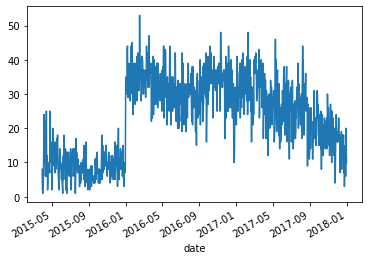

In [7]:
# number of fake and true news spread based on date
import calendar
from pyspark.sql.functions import col,to_timestamp, to_date, when, date_format
from calendar import month_abbr

d = {'January':1, 'February':2, 'March':3, 'April':4, 'May':5, 'June':6, 'July':7, 'August':8, 'September':9, 'October':10, 'November':11, 'Decenmber':12 }

df_pandas = df_fake.toPandas()
df_pandas['date'] = df_pandas.date.str.replace(',',"")

monthDict = {'Jan': '01', 'Feb':'02', 'Mar':'03', 'Apr':'04', 'May':'05', 'Jun':'06', 
            'Jul':'07', 'Aug':'08', 'Sep':'09', 'Oct':'10', 'Nov':'11', 'Dec':'12'}

from datetime import datetime

def check_date(x):
    correctDate = None
    try:
        correctDate=datetime.strptime(x, "%m-%d-%Y") 
    except ValueError:
        correctDate = None
    return correctDate


def convert(x):
    x[0] = x[0].capitalize()
    x[0] = x[0][0:3]
    if x[0] in monthDict.keys():
        x[0] = monthDict[x[0]]
    return x

df_pandas['date'] = df_pandas['date'].str.lower().map(lambda x: x.rstrip())
df_pandas['date'] = df_pandas['date'].str.lower().map(lambda x: x.split(' '))
df_pandas['date'] = df_pandas['date'].map(lambda x: convert(x))
df_pandas['date'] = df_pandas['date'].agg(lambda x: '-'.join(map(str, x)))
df_pandas['date'] = df_pandas['date'].map(lambda x:check_date(x))
df_pandas.groupby(df_pandas.date)['text'].count().plot(kind="line")


22/12/20 12:34:27 WARN TaskSetManager: Stage 3 contains a task of very large size (4983 KiB). The maximum recommended task size is 1000 KiB.


<AxesSubplot:xlabel='date'>

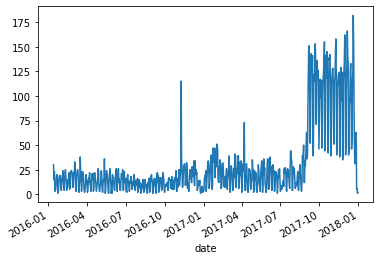

In [8]:
# number of true news spread based on date
import calendar
from pyspark.sql.functions import col,to_timestamp, to_date, when, date_format
from calendar import month_abbr

d = {'January':1, 'February':2, 'March':3, 'April':4, 'May':5, 'June':6, 'July':7, 'August':8, 'September':9, 'October':10, 'November':11, 'Decenmber':12 }

df_pandas = df_true.toPandas()
df_pandas['date'] = df_pandas.date.str.replace(',',"")

monthDict = {'Jan': '01', 'Feb':'02', 'Mar':'03', 'Apr':'04', 'May':'05', 'Jun':'06', 
            'Jul':'07', 'Aug':'08', 'Sep':'09', 'Oct':'10', 'Nov':'11', 'Dec':'12'}

from datetime import datetime

def check_date(x):
    correctDate = None
    try:
        correctDate=datetime.strptime(x, "%m-%d-%Y") 
    except ValueError:
        correctDate = None
    return correctDate


def convert(x):
    x[0] = x[0].capitalize()
    x[0] = x[0][0:3]
    if x[0] in monthDict.keys():
        x[0] = monthDict[x[0]]
    return x

df_pandas['date'] = df_pandas['date'].str.lower().map(lambda x: x.rstrip())
df_pandas['date'] = df_pandas['date'].str.lower().map(lambda x: x.split(' '))
df_pandas['date'] = df_pandas['date'].map(lambda x: convert(x))
df_pandas['date'] = df_pandas['date'].agg(lambda x: '-'.join(map(str, x)))
df_pandas['date'] = df_pandas['date'].map(lambda x:check_date(x))
df_pandas.groupby(df_pandas.date)['text'].count().plot(kind="line")


In [9]:
#types of news and highest number of news in order fromt he dataset
from pyspark.sql.functions import col

df.groupby('subject').count().sort(col("count").desc())

22/12/20 12:34:29 WARN TaskSetManager: Stage 4 contains a task of very large size (4983 KiB). The maximum recommended task size is 1000 KiB.
22/12/20 12:34:29 WARN TaskSetManager: Stage 7 contains a task of very large size (4983 KiB). The maximum recommended task size is 1000 KiB.


subject,count
politicsNews,11272
worldnews,10145
News,9050
politics,6841
left-news,4459
Government News,1570
US_News,783
Middle-east,778


22/12/20 12:34:30 WARN TaskSetManager: Stage 10 contains a task of very large size (4983 KiB). The maximum recommended task size is 1000 KiB.
22/12/20 12:34:30 WARN TaskSetManager: Stage 11 contains a task of very large size (4983 KiB). The maximum recommended task size is 1000 KiB.


<AxesSubplot:title={'center':'Points Scored by Team'}, ylabel='title'>

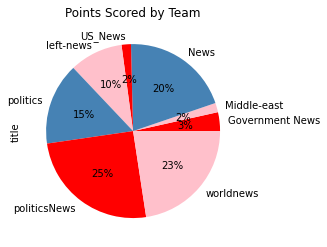

In [10]:
# Pie chart with counts of various news subjects Political and world news contained the highest counts .
from matplotlib import pyplot as plt

df1 = df

df1 = df1.toPandas()

colors = ['pink', 'silver', 'steelblue']

df1.groupby(['subject'])['title'].count().plot(kind='pie', y='count', autopct='%1.0f%%',
                                colors = ['red', 'pink', 'steelblue'],
                                title='Points Scored by Team')


In [11]:
# type of article which have fake news

df1_fake = df_fake

df1_fake.groupby(['subject']).count()

22/12/20 12:34:33 WARN TaskSetManager: Stage 14 contains a task of very large size (5255 KiB). The maximum recommended task size is 1000 KiB.
22/12/20 12:34:33 WARN TaskSetManager: Stage 17 contains a task of very large size (5255 KiB). The maximum recommended task size is 1000 KiB.


subject,count
News,9050
politics,6841
Government News,1570
left-news,4459
US_News,783
Middle-east,778


In [12]:
# type of article which have true news

df1_true = df_true

df1_true.groupby(['subject']).count()

22/12/20 12:34:35 WARN TaskSetManager: Stage 20 contains a task of very large size (4983 KiB). The maximum recommended task size is 1000 KiB.
22/12/20 12:34:35 WARN TaskSetManager: Stage 23 contains a task of very large size (4983 KiB). The maximum recommended task size is 1000 KiB.


subject,count
politicsNews,11272
worldnews,10145


In [13]:
# text pre-processing

from pyspark.sql.functions import col, split, lower, regexp_replace, length

df = df.select('title',(lower(regexp_replace('text', "[^a-zA-Z\\s]", "")).alias('text')), 'subject', 'date', 'flag')

In [14]:
# tokenize the text

from pyspark.ml.feature import Tokenizer

tokenizer = Tokenizer(inputCol='text', outputCol='words_token')

df = tokenizer.transform(df).select('title','words_token','subject','date','flag')

In [15]:
df.first()

22/12/20 12:34:43 WARN TaskSetManager: Stage 26 contains a task of very large size (4983 KiB). The maximum recommended task size is 1000 KiB.


Row(title='SPECTRE OF BENGHAZI: DOJ Drops Charges Against Alleged Arms Dealer of Libyan Weapons', words_token=['st', 'century', 'wire', 'says', 'the', 'us', 'department', 'of', 'justice', 'doj', 'is', 'dropping', 'all', 'charges', 'against', 'an', 'arms', 'dealer', 'whose', 'weapons', 'made', 'it', 'into', 'the', 'hands', 'of', 'radical', 'libya', 'militantsearly', 'this', 'week', 'a', 'motion', 'was', 'filed', 'by', 'the', 'doj', 'to', 'drop', 'charges', 'against', 'an', 'american', 'arms', 'dealer', 'named', 'marc', 'turi', 'according', 'to', 'federal', 'court', 'records', 'obtained', 'by', 'politicoalso', 'according', 'to', 'politico', 'the', 'deal', 'averts', 'a', 'trial', 'that', 'threatened', 'to', 'cast', 'additional', 'scrutiny', 'on', 'hillary', 'clinton', 's', 'private', 'emails', 'as', 'secretary', 'of', 'state', 'and', 'to', 'expose', 'reported', 'central', 'intelligence', 'agency', 'attempts', 'to', 'arm', 'rebels', 'fighting', 'libyan', 'leader', 'moammar', 'qadhafi', '',

In [16]:
#remove empty string from the frame
from pyspark.sql.functions import udf
import pyspark.sql.functions as f
from pyspark.sql.types import ArrayType

def space_removal(f):
    clean_tokens = []
    for tok in f:
        if tok:
            clean_tokens.append(tok)
    return clean_tokens

udf_space_removal = udf(space_removal, ArrayType(StringType()))

df = df.withColumn('words_token', udf_space_removal(f.col('words_token')))

In [17]:
df.first()

22/12/20 12:35:04 WARN TaskSetManager: Stage 27 contains a task of very large size (4983 KiB). The maximum recommended task size is 1000 KiB.
22/12/20 12:35:04 WARN TaskSetManager: Stage 28 contains a task of very large size (4983 KiB). The maximum recommended task size is 1000 KiB.


Row(title='SPECTRE OF BENGHAZI: DOJ Drops Charges Against Alleged Arms Dealer of Libyan Weapons', words_token=['st', 'century', 'wire', 'says', 'the', 'us', 'department', 'of', 'justice', 'doj', 'is', 'dropping', 'all', 'charges', 'against', 'an', 'arms', 'dealer', 'whose', 'weapons', 'made', 'it', 'into', 'the', 'hands', 'of', 'radical', 'libya', 'militantsearly', 'this', 'week', 'a', 'motion', 'was', 'filed', 'by', 'the', 'doj', 'to', 'drop', 'charges', 'against', 'an', 'american', 'arms', 'dealer', 'named', 'marc', 'turi', 'according', 'to', 'federal', 'court', 'records', 'obtained', 'by', 'politicoalso', 'according', 'to', 'politico', 'the', 'deal', 'averts', 'a', 'trial', 'that', 'threatened', 'to', 'cast', 'additional', 'scrutiny', 'on', 'hillary', 'clinton', 's', 'private', 'emails', 'as', 'secretary', 'of', 'state', 'and', 'to', 'expose', 'reported', 'central', 'intelligence', 'agency', 'attempts', 'to', 'arm', 'rebels', 'fighting', 'libyan', 'leader', 'moammar', 'qadhafi', 'li

In [18]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

[nltk_data] Error loading stopwords: <urlopen error [Errno 8] nodename
[nltk_data]     nor servname provided, or not known>


In [19]:
# remove the stop words
from pyspark.ml.feature import StopWordsRemover

stop_words_remover = StopWordsRemover(inputCol='words_token', outputCol='text').setStopWords(stop)

In [20]:
from pyspark.ml import Pipeline

stopWordRemovalPipeline = Pipeline(stages=[stop_words_remover])
pipelineFitRemoveStopWords = stopWordRemovalPipeline.fit(df)

In [21]:
df = pipelineFitRemoveStopWords.transform(df) #added here

In [22]:
df.first()

22/12/20 12:35:16 WARN TaskSetManager: Stage 31 contains a task of very large size (4983 KiB). The maximum recommended task size is 1000 KiB.
22/12/20 12:35:16 WARN TaskSetManager: Stage 32 contains a task of very large size (4983 KiB). The maximum recommended task size is 1000 KiB.


Row(title='SPECTRE OF BENGHAZI: DOJ Drops Charges Against Alleged Arms Dealer of Libyan Weapons', words_token=['st', 'century', 'wire', 'says', 'the', 'us', 'department', 'of', 'justice', 'doj', 'is', 'dropping', 'all', 'charges', 'against', 'an', 'arms', 'dealer', 'whose', 'weapons', 'made', 'it', 'into', 'the', 'hands', 'of', 'radical', 'libya', 'militantsearly', 'this', 'week', 'a', 'motion', 'was', 'filed', 'by', 'the', 'doj', 'to', 'drop', 'charges', 'against', 'an', 'american', 'arms', 'dealer', 'named', 'marc', 'turi', 'according', 'to', 'federal', 'court', 'records', 'obtained', 'by', 'politicoalso', 'according', 'to', 'politico', 'the', 'deal', 'averts', 'a', 'trial', 'that', 'threatened', 'to', 'cast', 'additional', 'scrutiny', 'on', 'hillary', 'clinton', 's', 'private', 'emails', 'as', 'secretary', 'of', 'state', 'and', 'to', 'expose', 'reported', 'central', 'intelligence', 'agency', 'attempts', 'to', 'arm', 'rebels', 'fighting', 'libyan', 'leader', 'moammar', 'qadhafi', 'li

In [23]:
# most freq words in data

from pyspark.sql.functions import concat_ws

df_freq = df.withColumn("text", concat_ws(" ", df["text"]))

df_freq.show(5)

22/12/20 12:35:36 WARN TaskSetManager: Stage 35 contains a task of very large size (4983 KiB). The maximum recommended task size is 1000 KiB.
22/12/20 12:35:36 WARN TaskSetManager: Stage 36 contains a task of very large size (4983 KiB). The maximum recommended task size is 1000 KiB.
+--------------------+--------------------+---------+------------------+----+--------------------+
|               title|         words_token|  subject|              date|flag|                text|
+--------------------+--------------------+---------+------------------+----+--------------------+
|SPECTRE OF BENGHA...|[st, century, wir...|  US_News|   October 5, 2016|   0|st century wire s...|
|LOL! ONE HILARIOU...|[watching, sports...| politics|      Sep 28, 2017|   0|watching sports t...|
|Britain to submit...|[london, reuters,...|worldnews|November 19, 2017 |   1|london reuters br...|
|Russia's Lavrov t...|[moscow, reuters,...|worldnews|December 26, 2017 |   1|moscow reuters ru...|
| Anti-Gay Pastor ...|[

In [24]:
# most frequent fake words

df_fake_freq = df_freq.filter(df["flag"] == 0)

df_fake_text = df_fake_freq.select("text")


In [25]:
from pyspark.sql.functions import explode

df_fake_text = df_fake_text\
.withColumn("words", split(col("text"), " "))\
.where(length("text")>0)

df_freq_fake = df_fake_text\
.select(explode(col("words")).alias("word"))\
.groupBy("word").count()\

df_freq_fake.orderBy(col("count").desc()).show()

22/12/20 12:35:41 WARN TaskSetManager: Stage 39 contains a task of very large size (4983 KiB). The maximum recommended task size is 1000 KiB.


22/12/20 12:35:44 WARN TaskSetManager: Stage 40 contains a task of very large size (4983 KiB). The maximum recommended task size is 1000 KiB.


+---------+-----+
|     word|count|
+---------+-----+
|    trump|73933|
|     said|31013|
|   people|25963|
|president|25586|
|    would|23427|
|      one|22935|
|       us|22049|
|  clinton|18011|
|    obama|17813|
|     like|17621|
|   donald|17215|
|     also|15242|
|      new|14158|
|     news|14126|
|     even|13717|
|  hillary|13565|
|    white|12778|
|     time|12728|
|    state|12525|
|      via|11273|
+---------+-----+
only showing top 20 rows



In [26]:
#graph representtion of most frequent words in fake news
# import seaborn as sns 

# df_graph_fake = df_freq_fake.orderBy(col("count").desc())

# df_graph_fake = df_graph_fake.toPandas()

# ax = sns.barplot(data = df_graph_fake, x = "word", y = "count", color = 'blue')
# ax.set(ylabel = "count")
# plt.xticks(rotation='vertical')
# plt.show()

In [27]:
#most true words

df_true_freq = df_freq.filter(df["flag"] == 1)

df_true_text = df_true_freq.select("text")

In [28]:
from pyspark.sql.functions import explode

df_true_text = df_true_text\
.withColumn("words", split(col("text"), " "))\
.where(length("text")>0)

df_freq_true = df_true_text\
.select(explode(col("words")).alias("word"))\
.groupBy("word").count()\

df_freq_true.orderBy(col("count").desc()).show()

22/12/20 12:35:54 WARN TaskSetManager: Stage 46 contains a task of very large size (4983 KiB). The maximum recommended task size is 1000 KiB.


22/12/20 12:35:56 WARN TaskSetManager: Stage 47 contains a task of very large size (4983 KiB). The maximum recommended task size is 1000 KiB.


+----------+-----+
|      word|count|
+----------+-----+
|      said|98985|
|     trump|42577|
|        us|41137|
|     would|31514|
|   reuters|28306|
| president|25533|
|     state|18753|
|government|17976|
|    states|17634|
|       new|16785|
|     house|16405|
|      also|15944|
|    united|15572|
|republican|15288|
|    people|15111|
|      told|14242|
|     could|13697|
|       one|12674|
|      last|12613|
|washington|12140|
+----------+-----+
only showing top 20 rows



In [29]:
df_freq.printSchema()

root
 |-- title: string (nullable = true)
 |-- words_token: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- subject: string (nullable = true)
 |-- date: string (nullable = true)
 |-- flag: integer (nullable = false)
 |-- text: string (nullable = false)



In [30]:
df_freq.count()

22/12/20 12:36:03 WARN TaskSetManager: Stage 53 contains a task of very large size (4983 KiB). The maximum recommended task size is 1000 KiB.


44898

In [31]:
# drop unwanted coloumns

df_ml = df_freq.drop("title","words_token","date")
df_ml.printSchema()

root
 |-- subject: string (nullable = true)
 |-- flag: integer (nullable = false)
 |-- text: string (nullable = false)



In [32]:
from pyspark.sql.functions import monotonically_increasing_id 

df_ml = df_ml.select("*").withColumn("id", monotonically_increasing_id())

df_ml.show()

22/12/20 12:36:11 WARN TaskSetManager: Stage 56 contains a task of very large size (4983 KiB). The maximum recommended task size is 1000 KiB.
22/12/20 12:36:11 WARN TaskSetManager: Stage 57 contains a task of very large size (4983 KiB). The maximum recommended task size is 1000 KiB.
+------------+----+--------------------+---+
|     subject|flag|                text| id|
+------------+----+--------------------+---+
|     US_News|   0|st century wire s...|  0|
|    politics|   0|watching sports t...|  1|
|   worldnews|   1|london reuters br...|  2|
|   worldnews|   1|moscow reuters ru...|  3|
|        News|   0|hypocrite got ass...|  4|
|politicsNews|   1|washington reuter...|  5|
|   worldnews|   1|benghazi libya re...|  6|
|politicsNews|   1|philadelphia reut...|  7|
|    politics|   0|liberal lunacy ta...|  8|
|   worldnews|   1|lima reuters gove...|  9|
|     US_News|   0|st century wire s...| 10|
|politicsNews|   1|washington reuter...| 11|
|   left-news|   0|san fransisco er ...| 

In [33]:
# x values and Y values

x = df_ml.select('text').rdd.flatMap(lambda x: x).collect()
y = df_ml.select('flag').rdd.flatMap(lambda x: x).collect()

22/12/20 12:36:14 WARN TaskSetManager: Stage 60 contains a task of very large size (4983 KiB). The maximum recommended task size is 1000 KiB.
22/12/20 12:36:14 WARN TaskSetManager: Stage 61 contains a task of very large size (4983 KiB). The maximum recommended task size is 1000 KiB.


22/12/20 12:36:18 WARN TaskSetManager: Stage 64 contains a task of very large size (4983 KiB). The maximum recommended task size is 1000 KiB.
22/12/20 12:36:18 WARN TaskSetManager: Stage 65 contains a task of very large size (4983 KiB). The maximum recommended task size is 1000 KiB.


In [34]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=.25)

In [35]:
# print(x_train[0])
# print(y_train[0])

In [36]:
#vectorize the text

from sklearn.feature_extraction.text import TfidfVectorizer

In [37]:
vectorization = TfidfVectorizer()
xv_train = vectorization.fit_transform(x_train)
xv_test = vectorization.transform(x_test)

In [38]:
xv_train

<33673x185435 sparse matrix of type '<class 'numpy.float64'>'
	with 5448855 stored elements in Compressed Sparse Row format>

In [39]:
xv_train.toarray()[0]

array([0., 0., 0., ..., 0., 0., 0.])

In [40]:
from sklearn.linear_model import LogisticRegression

In [41]:
LR = LogisticRegression()
LR.fit(xv_train, y_train)

LogisticRegression()

In [42]:
LR.score(xv_test, y_test)

0.98913140311804

In [43]:
pred_LR = LR.predict(xv_test)

In [44]:
print(classification_report(y_test, pred_LR))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5800
           1       0.99      0.99      0.99      5425

    accuracy                           0.99     11225
   macro avg       0.99      0.99      0.99     11225
weighted avg       0.99      0.99      0.99     11225



In [45]:
import re, string
def wordopt(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub("\\W"," ",text) 
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)    
    return text

In [46]:
import pandas as pd
def output_lable(n):
    if n == 0:
        return "Fake News"
    elif n == 1:
        return "Not A Fake News"
    
def manual_testing(news):
    testing_news = {"text":[news]}
    new_def_test = pd.DataFrame(testing_news)
    new_def_test["text"] = new_def_test["text"].apply(wordopt) 
    new_x_test = new_def_test["text"]
    new_xv_test = vectorization.transform(new_x_test)
    pred_LR = LR.predict(new_xv_test)
    print("*****")
    #print(pred_LR[0])
    print(new_xv_test)
    print(type(pred_LR[0]))
    # pred_DT = DT.predict(new_xv_test)
    # pred_GBC = GBC.predict(new_xv_test)
    # pred_RFC = RFC.predict(new_xv_test)

    return print("\n\nLR Prediction: {} \n".format(output_lable(pred_LR[0])))

In [48]:
news = str(input())
manual_testing(news)

 WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Representative Mark Meadows, speaking on CBS’ “Face the Nation,” drew a hard line on federal spending, which lawmakers are bracing to do battle over in January. When they return from the holidays on Wednesday, lawmakers will begin trying to pass a federal budget in a fight likely to be linked to other issues, such as immigration policy, even as the November congressional election campaigns approach in which Republicans will seek to keep control of Congress. President Donald Trump and his Republicans want a big budget increase in military spending, while Democrats also want proportional increases for non-defense “discretionary” spending on programs that support educat

*****
  (0, 184300)	0.030284592452602826
  (0, 183963)	0.025552917242098468
  (0, 183596)	0.05686888420837353
  (0, 182340)	0.03953335405133784
  (0, 181799)	0.022496249918185843
  (0, 180573)	0.0344853204956523
  (0, 180474)	0.06058334243937645
  (0, 179958)	0.019212449761248803
  (0, 179393)	0.02569396123834514
  (0, 179049)	0.02098274836156773
  (0, 179040)	0.04387130739683543
  (0, 178719)	0.03497764823136557
  (0, 178622)	0.04431847002006811
  (0, 178106)	0.02049935730260634
  (0, 177603)	0.03685646459559613
  (0, 177180)	0.05481770743042387
  (0, 177152)	0.04370261192440142
  (0, 176973)	0.06048029273066762
  (0, 176478)	0.03101885513125031
  (0, 176339)	0.09570963506921168
  (0, 173525)	0.024324999080356742
  (0, 173339)	0.03303672877213291
  (0, 172251)	0.018227433125601704
  (0, 170236)	0.02554183097652187
  (0, 169312)	0.02554404697854207
  :	:
  (0, 19141)	0.02974063612999503
  (0, 19073)	0.038035505114855934
  (0, 17072)	0.03909240522264433
  (0, 16973)	0.05806492840978547
